# Milestone 1: Frame your analysis and EDA




## 1. Project Topics

### Exploratory 1

#### Business Goals

Determine if NSFW posts post affects user interaction.

#### Technical Proposals

Check the means of the distribution of comments for each type of post in a box plot. Perform hypothesis tests. Perform hypothesis tests for statistical significance.




### Exploratory 2

#### Business Goals

Determine what is the correlation that exists between the number of comments and the score of a post.

#### Technical Proposals

Calculate correlations between the score in various selected subreddits and the number of comments in each. Perform hypothesis tests for statistical significance.


### Exploratory 3

#### Business Goals

Determine the times of the day when posts typically receive the most engagement.

#### Technical Proposals

Plot comments over time.

## 2. EDA

### Bucket checks

In [2]:
!aws s3 ls


2023-08-29 23:43:16 sagemaker-studio-692960231031-wo7kgoszj2g
2023-08-29 23:50:01 sagemaker-us-east-1-692960231031
2023-08-30 00:34:21 vad49
2023-09-16 16:02:10 vad49-labdata


In [65]:
#!aws s3 ls s3://vad49/project_lowercase_test/
!aws s3 ls s3://project17-bucket-alex/project_jan2021/

#!aws s3 cp s3://project17-bucket-alex/eda_ideas.txt -

                           PRE comments/
                           PRE submissions/


### Setup

In [ ]:
# Setup - Run only once per Kernel App
%conda install openjdk -y

# install PySpark
%pip install pyspark==3.2.0 s3fs pyarrow

# restart kernel
HTML("<script>Jupyter.notebook.kernel.restart()</script>")


In [36]:
from IPython.core.display import HTML
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import col, length, isnan, when, count
import pandas as pd
pd.set_option('display.max_colwidth', 50) 
#pd.set_option('display.width', None)
pd.set_option('display.max_columns', None)


In [ ]:
# Import pyspark and build Spark session

spark = (
    SparkSession.builder.appName("PySparkApp")
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.2.2")
    .config(
        "fs.s3a.aws.credentials.provider",
        "com.amazonaws.auth.ContainerCredentialsProvider",
    )
    .getOrCreate()
)

print(spark.version)

### Bring in submissions and comments data

In [6]:
%%time
s3_path_submissions = f"s3a://project17-bucket-alex/project_jan2021//submissions"
print(f"reading submissions from {s3_path_submissions}")

submissions = spark.read.parquet(s3_path_submissions, header=True)


reading submissions from s3a://project17-bucket-alex/project_jan2021//submissions


23/11/07 22:01:29 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


CPU times: user 10.4 ms, sys: 0 ns, total: 10.4 ms
Wall time: 7.33 s


23/11/07 22:01:36 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [7]:
%%time
s3_path_comments = f"s3a://project17-bucket-alex/project_jan2021//comments"
print(f"reading submissions from {s3_path_comments}")

comments = spark.read.parquet(s3_path_comments, header=True)


reading submissions from s3a://project17-bucket-alex/project_jan2021//comments
CPU times: user 4.63 ms, sys: 68 µs, total: 4.7 ms
Wall time: 769 ms


In [8]:
submissions_small = submissions.sample(withReplacement=False, fraction=0.01, seed=42)
comments_small = comments.sample(withReplacement=False, fraction=0.01, seed=42)


In [27]:
# create small dfs

use_small = True  # to easily swap between the small and small dfs
submissions_active = submissions_small if use_small else submissions
comments_active = comments_small if use_small else comments


### 2.1 Report on the basic info about your dataset. What are the interesting columns? What is the schema? How many rows do you have? etc. etc.


In [10]:

print(f"submissions shape: ({submissions_active.count()}, {len(submissions_active.columns)})")
print(f"submissions shape: ({comments_active.count()}, {len(comments_active.columns)})")




submissions shape: (2628, 68)


submissions shape: (41245, 21)


Submissions

In [11]:
submissions_active.printSchema()

root
 |-- adserver_click_url: string (nullable = true)
 |-- adserver_imp_pixel: string (nullable = true)
 |-- archived: boolean (nullable = true)
 |-- author: string (nullable = true)
 |-- author_cakeday: boolean (nullable = true)
 |-- author_flair_css_class: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- author_id: string (nullable = true)
 |-- brand_safe: boolean (nullable = true)
 |-- contest_mode: boolean (nullable = true)
 |-- created_utc: timestamp (nullable = true)
 |-- crosspost_parent: string (nullable = true)
 |-- crosspost_parent_list: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- approved_at_utc: string (nullable = true)
 |    |    |-- approved_by: string (nullable = true)
 |    |    |-- archived: boolean (nullable = true)
 |    |    |-- author: string (nullable = true)
 |    |    |-- author_flair_css_class: string (nullable = true)
 |    |    |-- author_flair_text: string (nullable = true)
 |    |    

Comments

In [13]:
comments_active.printSchema()

root
 |-- author: string (nullable = true)
 |-- author_cakeday: boolean (nullable = true)
 |-- author_flair_css_class: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- body: string (nullable = true)
 |-- can_gild: boolean (nullable = true)
 |-- controversiality: long (nullable = true)
 |-- created_utc: timestamp (nullable = true)
 |-- distinguished: string (nullable = true)
 |-- edited: string (nullable = true)
 |-- gilded: long (nullable = true)
 |-- id: string (nullable = true)
 |-- is_submitter: boolean (nullable = true)
 |-- link_id: string (nullable = true)
 |-- parent_id: string (nullable = true)
 |-- permalink: string (nullable = true)
 |-- retrieved_on: timestamp (nullable = true)
 |-- score: long (nullable = true)
 |-- stickied: boolean (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- subreddit_id: string (nullable = true)



### 2.2 Conduct basic data quality checks! Make sure there are no missing values, check the length of the comments, and remove rows of data that might be corrupted. Even if you think all your data is perfect, you still need to demonstrate that with your analysis.



In [28]:

def check_and_remove_missing(df: DataFrame, threshold: int = 100) -> DataFrame:

    # Check for missing values
    missing_values = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])

    # Show the missing values count for each column
    missing_values_collected = missing_values.collect()[0].asDict()
    print("Missing values in each column:")
    for column, missing_count in missing_values_collected.items():
        print(f"{column}: {missing_count}")

    # Identify columns with missing values above threshold
    columns_to_drop = [column for column, missing_count in missing_values_collected.items() if missing_count > threshold]

    # Drop the identified columns from the dataframe
    df = df.drop(*columns_to_drop)
    
    # Recalculate missing values for the updated DataFrame
    missing_values = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
    missing_values_collected = missing_values.collect()[0].asDict()
    
    # Print updated missing values count
    print("Missing values after column removal:")
    for column, missing_count in missing_values_collected.items():
        print(f"{column}: {missing_count}")
    
    return df



In [29]:
submissions_active = check_and_remove_missing(submissions_active)



Missing values in each column:
adserver_click_url: 2628
adserver_imp_pixel: 2628
archived: 0
author: 0
author_cakeday: 2623
author_flair_css_class: 2608
author_flair_text: 2586
author_id: 2628
brand_safe: 2628
contest_mode: 0
created_utc: 0
crosspost_parent: 2626
crosspost_parent_list: 2626
disable_comments: 2628
distinguished: 2627
domain: 0
domain_override: 2628
edited: 0
embed_type: 2628
embed_url: 2628
gilded: 0
hidden: 0
hide_score: 0
href_url: 2628
id: 0
imp_pixel: 2628
is_crosspostable: 0
is_reddit_media_domain: 0
is_self: 0
is_video: 0
link_flair_css_class: 2095
link_flair_text: 2019
locked: 0
media: 2626
media_embed: 0
mobile_ad_url: 2628
num_comments: 0
num_crossposts: 0
original_link: 2628
over_18: 0
parent_whitelist_status: 0
permalink: 0
pinned: 0
post_hint: 2609
preview: 2609
promoted: 2628
promoted_by: 2628
promoted_display_name: 2628
promoted_url: 2628
retrieved_on: 2628
score: 0
secure_media: 2626
secure_media_embed: 0
selftext: 0
spoiler: 0
stickied: 0
subreddit: 0
su

Missing values after column removal:
archived: 0
author: 0
contest_mode: 0
created_utc: 0
domain: 0
edited: 0
gilded: 0
hidden: 0
hide_score: 0
id: 0
is_crosspostable: 0
is_reddit_media_domain: 0
is_self: 0
is_video: 0
locked: 0
media_embed: 0
num_comments: 0
num_crossposts: 0
over_18: 0
parent_whitelist_status: 0
permalink: 0
pinned: 0
score: 0
secure_media_embed: 0
selftext: 0
spoiler: 0
stickied: 0
subreddit: 0
subreddit_id: 0
thumbnail: 0
title: 0
url: 0
whitelist_status: 0


In [30]:
# turn to int for displaying

columns_to_cast_submissions = [
    "archived", "contest_mode", "hidden", "hide_score", 
    "is_crosspostable", "is_reddit_media_domain", "is_self",
    "is_video", "locked", "over_18", "pinned", "spoiler", "stickied"
]

for column_name in columns_to_cast_submissions:
    submissions_active = submissions_active.withColumn(column_name, col(column_name).cast("integer"))

    

Let's remove submissions without a body should obviously go, but what about the submissions without a self text (deleted, removed or empty). We can keep where the author is empty.

In [33]:

def clean_submissions(df: DataFrame) -> DataFrame:
    
    # Define a list of conditions that would indicate a row needs to be removed
    conditions = (col('selftext') != "[removed]") & (col('selftext') != "[deleted]") & (col('selftext').isNotNull() & (col('selftext') != ""))

    # Apply the filter
    cleaned_df = df.filter(conditions)
    
    return cleaned_df




In [34]:
submissions_active = clean_submissions(submissions_active)


In [37]:
display(submissions_active.limit(5).toPandas())

,archived,author,contest_mode,created_utc,domain,edited,gilded,hidden,hide_score,id,is_crosspostable,is_reddit_media_domain,is_self,is_video,locked,media_embed,num_comments,num_crossposts,over_18,parent_whitelist_status,permalink,pinned,score,secure_media_embed,selftext,spoiler,stickied,subreddit,subreddit_id,thumbnail,title,url,whitelist_status
0,0,techsavvynerd91,0,2021-01-02 00:11:05,self.NoStupidQuestions,false,0,0,0,komhp2,1,0,1,0,0,"(None, None, None, None)",8,0,0,all_ads,/r/NoStupidQuestions/comments/komhp2/how_do_yo...,0,2,"(None, None, None, None, None)",For those that wear glasses and have managed t...,0,0,NoStupidQuestions,t5_2w844,self,How do you prevent your glasses from falling o...,https://www.reddit.com/r/NoStupidQuestions/com...,all_ads
1,0,irtriated,0,2021-01-23 05:40:24,self.relationship_advice,false,0,0,0,l3684b,1,0,1,0,0,"(None, None, None, None)",2,0,0,all_ads,/r/relationship_advice/comments/l3684b/boyfrie...,0,8,"(None, None, None, None, None)",My (33F) boyfriend (37M) and I live in a 2-br ...,0,0,relationship_advice,t5_2r0cn,self,Boyfriend too loud,https://www.reddit.com/r/relationship_advice/c...,all_ads
2,0,RegretSubstantial365,0,2021-01-25 03:56:10,self.relationship_advice,false,0,0,0,l4fdip,1,0,1,0,0,"(None, None, None, None)",7,0,0,all_ads,/r/relationship_advice/comments/l4fdip/lonely_...,0,2,"(None, None, None, None, None)","I've been with this guy for about 10 months, h...",0,0,relationship_advice,t5_2r0cn,self,Lonely in a relationship,https://www.reddit.com/r/relationship_advice/c...,all_ads
3,0,[deleted],0,2021-01-23 16:19:24,self.relationship_advice,1.611419127E9,0,0,0,l3f16q,1,0,1,0,0,"(None, None, None, None)",5,0,0,all_ads,/r/relationship_advice/comments/l3f16q/how_wou...,0,4,"(None, None, None, None, None)",My bestfriend went to a date yesterday with a ...,0,0,relationship_advice,t5_2r0cn,self,How would you tell your bestfriend she’s datin...,https://www.reddit.com/r/relationship_advice/c...,all_ads
4,0,CallMeSpoofy,0,2021-01-23 16:38:59,self.NoStupidQuestions,false,0,0,0,l3ff0a,1,0,1,0,0,"(None, None, None, None)",6,0,0,all_ads,/r/NoStupidQuestions/comments/l3ff0a/is_it_pos...,0,1,"(None, None, None, None, None)",In my case it’s not one big stain but little s...,0,0,NoStupidQuestions,t5_2w844,self,Is it possible to get bleach out of clothes?,https://www.reddit.com/r/NoStupidQuestions/com...,all_ads


Comments

In [32]:
comments_active = check_and_remove_missing(comments_active)



Missing values in each column:
author: 0
author_cakeday: 41104
author_flair_css_class: 40417
author_flair_text: 35282
body: 0
can_gild: 0
controversiality: 0
created_utc: 0
distinguished: 40003
edited: 0
gilded: 0
id: 0
is_submitter: 0
link_id: 0
parent_id: 0
permalink: 0
retrieved_on: 0
score: 0
stickied: 0
subreddit: 0
subreddit_id: 0


Missing values after column removal:
author: 0
body: 0
can_gild: 0
controversiality: 0
created_utc: 0
edited: 0
gilded: 0
id: 0
is_submitter: 0
link_id: 0
parent_id: 0
permalink: 0
retrieved_on: 0
score: 0
stickied: 0
subreddit: 0
subreddit_id: 0


Now on to the comments.

Let's do the same for the body of the comments.

In [38]:
def clean_comments(df: DataFrame) -> DataFrame:
    
    # Define the filter conditions
    conditions = (col('body') != "[removed]") & (col('body') != "[deleted]") & (col('body').isNotNull() & (col('body') != ""))

    # Apply the filter
    cleaned_df = df.filter(conditions)
    
    return cleaned_df




In [ ]:
comments_active = clean_comments(comments_active)


In [40]:
# turn to ints for displaying
columns_to_cast_comments = [
    "can_gild", "stickied", "is_submitter"
]

for column_name in columns_to_cast_comments:
    comments_active = comments_active.withColumn(column_name, col(column_name).cast("integer"))





In [41]:
display(comments_active.limit(5).toPandas())

,author,body,can_gild,controversiality,created_utc,edited,gilded,id,is_submitter,link_id,parent_id,permalink,retrieved_on,score,stickied,subreddit,subreddit_id
0,stonedironworker,Every man you’ve ever slept with has watched p...,1,0,2021-01-28 15:18:53,false,0,gl3msfm,0,t3_l6okyk,t1_gl3ljhf,/r/unpopularopinion/comments/l6okyk/i_dont_wan...,2021-05-29 06:07:54,41,0,unpopularopinion,t5_2tk0s
1,[deleted],That’s what I’m saying man. Where are the men ...,0,0,2021-01-28 15:19:23,1611870280,0,gl3mwdx,0,t3_l6wmz9,t1_gl3i3ry,/r/AskMen/comments/l6wmz9/men_of_reddit_whats_...,2021-05-29 06:08:43,101,0,AskMen,t5_2s30g
2,slimezillaaa,Sounds like more of a insecurity rather than a...,1,0,2021-01-28 15:19:59,false,0,gl3n144,0,t3_l6okyk,t3_l6okyk,/r/unpopularopinion/comments/l6okyk/i_dont_wan...,2021-05-29 06:10:08,1,0,unpopularopinion,t5_2tk0s
3,chanaandeler_bong,Why does that matter. In either form you aren’...,1,1,2021-01-28 15:22:42,false,0,gl3nmln,0,t3_l6okyk,t1_gl3n5rb,/r/unpopularopinion/comments/l6okyk/i_dont_wan...,2021-05-29 06:14:35,0,0,unpopularopinion,t5_2tk0s
4,AutoModerator,**PLEASE READ ALL OF THIS BEFORE MESSAGING US:...,1,0,2021-01-28 15:26:24,false,0,gl3ofzn,0,t3_l6zjdh,t3_l6zjdh,/r/OutOfTheLoop/comments/l6zjdh/what_is_actual...,2021-05-29 06:21:05,1,0,OutOfTheLoop,t5_2xinb


Final shape

In [43]:

print(f"submissions shape: ({submissions_active.count()}, {len(submissions_active.columns)})")
print(f"submissions shape: ({comments_active.count()}, {len(comments_active.columns)})")


submissions shape: (742, 33)


submissions shape: (37928, 17)


### 2.3 Produce at least 5 interesting graphs about your dataset. Think about the dimensions that are interesting for your Reddit data! There are millions of choices. Make sure your graphs are connected to your business questions.



In [45]:
submissions_active.groupby('over_18').count().show()


+-------+-----+
|over_18|count|
+-------+-----+
|      1|    8|
|      0|  734|
+-------+-----+



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Get the number of true cases for over_18
true_count = submissions_active.filter(col('over_18') == 1).count()

# Sample the same number of false cases
false_count = submissions_active.filter(col('over_18') == 0).count()
fraction = true_count / false_count

# Use sampleBy if you need stratified sampling to maintain a proportion
sampled_false = submissions_active.filter(col('over_18') == 0).sample(withReplacement=False, fraction=fraction, seed=42)

# Since you need exactly `true_count` number of samples, we need to take action in the sampled DataFrame
# This may cause Spark to scan the DataFrame twice
sampled_false = sampled_false.limit(true_count)

# Combine the true cases and sampled false cases
combined = submissions_active.filter(col('over_18') == 1).unionAll(sampled_false)



<Figure size 1000x600 with 0 Axes>

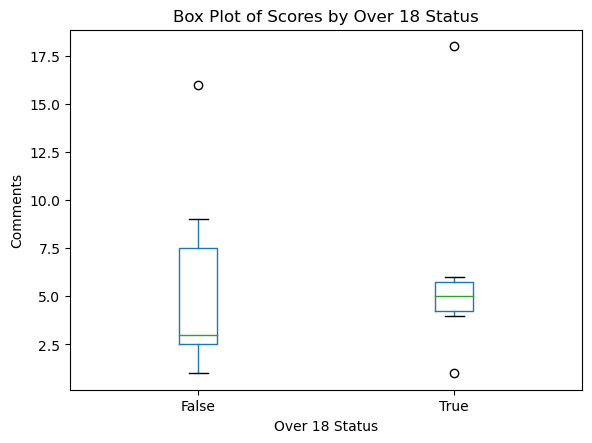

In [55]:
# Now convert this combined Spark DataFrame to Pandas DataFrame for visualization (assuming the data is small enough to fit into memory)
pandas_df = combined.toPandas()

# Ensure 'over_18' is a string to be treated as categorical data
pandas_df['over_18'] = pandas_df['over_18'].map({0: 'False', 1: 'True'})


# Calculate the mean and standard deviation of num_comments
#mean_comments = pandas_df['num_comments'].mean()
#std_comments = pandas_df['num_comments'].std()

# Define the upper bound as 3 standard deviations above the mean
#upper_bound = mean_comments + 3 * std_comments


# remove rows with more than 200 comments
pandas_df = pandas_df[pandas_df['num_comments'] <= 200]



# Filter the DataFrame to exclude any num_comments above the upper bound
pandas_df = pandas_df[pandas_df['num_comments'] <= upper_bound]

# Create a box plot for the score by over_18 status
plt.figure(figsize=(10, 6))
ax = pandas_df.boxplot(by='over_18', column=['num_comments'], grid=False)

# Set the title and labels
ax.set_title('Box Plot of Scores by Over 18 Status')
ax.set_xlabel('Over 18 Status')
ax.set_ylabel('Comments')
plt.suptitle('')  # Suppress the automatic Pandas-generated title

# Show the plot
plt.show()

In [53]:
counts = pandas_df['over_18'].value_counts()
print("Counts for 'over_18' in the DataFrame:")
print(counts)


Counts for 'over_18' in the DataFrame:
True     8
False    8
Name: over_18, dtype: int64


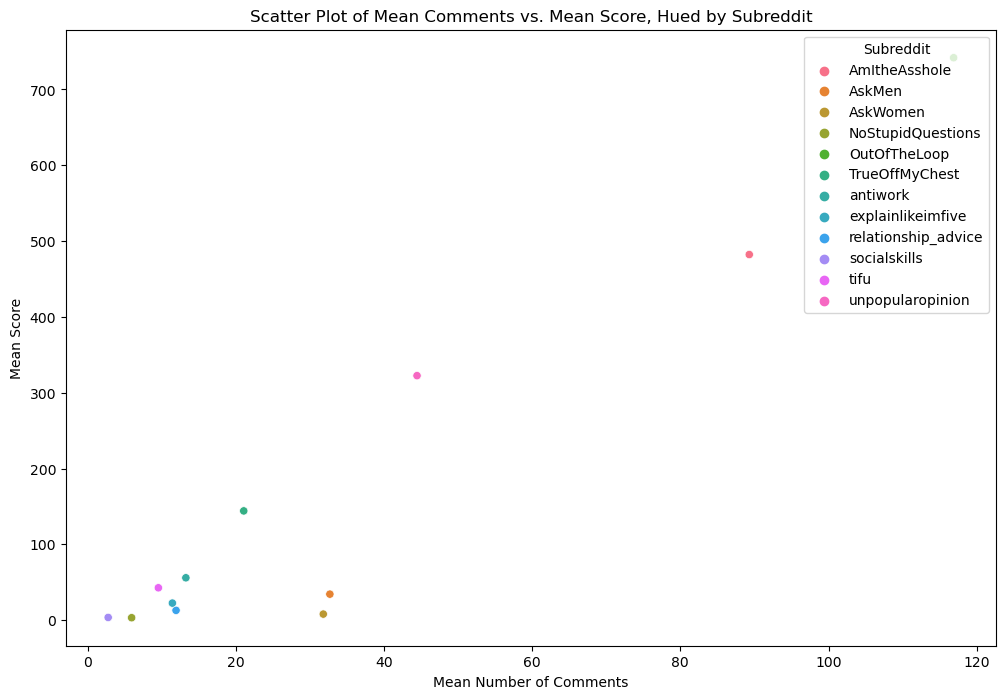

In [56]:
from pyspark.sql import functions as F

# Group by 'subreddit' and calculate the mean of 'num_comments' and 'score'
subreddit_means = submissions_active.groupBy('subreddit') \
                                    .agg(F.mean('num_comments').alias('mean_num_comments'), 
                                         F.mean('score').alias('mean_score'))

# Now convert this Spark DataFrame to a Pandas DataFrame
pandas_df_means = subreddit_means.toPandas()

# Ensure the 'subreddit' is treated as a category for better plotting
pandas_df_means['subreddit'] = pandas_df_means['subreddit'].astype('category')

# Now plot using seaborn for better hue handling
import seaborn as sns
import matplotlib.pyplot as plt

# Create the scatter plot
plt.figure(figsize=(12, 8))
scatter_plot = sns.scatterplot(data=pandas_df_means, 
                               x='mean_num_comments', 
                               y='mean_score', 
                               hue='subreddit')

# Enhance the plot
scatter_plot.set_title('Scatter Plot of Mean Comments vs. Mean Score, Hued by Subreddit')
scatter_plot.set_xlabel('Mean Number of Comments')
scatter_plot.set_ylabel('Mean Score')
plt.legend(title='Subreddit', loc='upper right')

# Show the plot
plt.show()


### 2.4 Produce at least 3 interesting summary tables about your dataset. You can decide how to split up your data into categories, time slices, etc. There are infinite ways you can make summary statistics. Be unique, creative, and interesting!



In [73]:
submissions_active.groupby('subreddit').count().show()



+-------------------+-----+
|          subreddit|count|
+-------------------+-----+
|     TrueOffMyChest|  117|
|   unpopularopinion|  416|
|           antiwork|   22|
|       socialskills|   42|
|             AskMen|  140|
|      AmItheAsshole|  325|
|relationship_advice|  665|
|  explainlikeimfive|  162|
|       OutOfTheLoop|   58|
|               tifu|   64|
|  NoStupidQuestions|  509|
|           AskWomen|  108|
+-------------------+-----+



### 2.5 Use data transformations to make AT LEAST 3 new variables that are relevant to your business questions. We cannot be more specific because this depends on your project and what you want to explore!



### 2.6 Implement regex searches for specific keywords of interest to produce dummy variables and then make statistics that are related to your business questions. Note, that you DO NOT have to do textual cleaning of the data at this point. The next assignment on NLP will focus on the textual cleaning and analysis aspect.



### 2.7 Find some type of external data to join onto your Reddit data. Don’t know what to pick? Consider a time-related dataset. Stock prices, game details over time, active users on a platform, sports scores, covid cases, etc., etc. While you may not need to join this external data with your entire dataset, you must have at least one analysis that connects to external data. You do not have to join the external data and analyze it yet, just find it.



### If you are planning to make any custom datasets that are derived from your Reddit data, make them now. These datasets might be graph-focused, or maybe they are time series focused, it is completely up to you!